# Introductions to Satellite Data: Part I
## Working with GOES
The Geostationary Orbiting Environmental Satillete (GOES) is a major contributor to the realm of atmospheric data science. For additional information on the background of the data mentioned in this tutorial, preview [this presentation](https://noaa-goes16.s3.amazonaws.com/Beginners_Guide_to_GOES-R_Series_Data.pdf).

**Note:** If you really don't want to read any of this and you just need to look at code, [follow this link]() to get a good ol' python script that will get the job done. 
### Goal
In this tutorial we will demonstrate how to freely pull raw data and the data products that the GOES series measures and generates. 
We will aim to hit these main points:
1. Methods of pulling data
2. Mapping out data products
3. Looking at the raw data
4. Pulling data for a specific location


### Prerequistes
*A small note: In this tutorial we will be using matplotlib's Basemap library for mapping out the data.*

In the following cell there are a series of import statements for libraries that are required for the tutorial. In addition, you will need to install `aiohttp`, `h5netcdf`, and `folium`. 

In [2]:
import boto3
import botocore
import requests
import xarray as xr
from mpl_toolkits.basemap import Basemap
import time
import warnings
import datetime as dt

import fsspec

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.dates as dates
from metpy.units import units
# from siphon.simplewebservice.wyoming import WyomingUpperAir
# from siphon.http_util import HTTPEndPoint

## Data Acquistion 
Thanks to the NOAA Big Data Project, all of the data that GOES measures and computes is available to the public through Amazon Web Service (AWS). There is a brief information guide that can be accessed [here](https://github.com/awslabs/open-data-docs/tree/main/docs/noaa/noaa-goes16). 

Since the data is stored on AWS we can access it via the boto3 library, as shown.

In [3]:
s3 = boto3.resource('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))
goes = s3.Bucket('noaa-goes16')

Now we must select a date to collect data for and the specific data product. For this section of the tutorial we will use my birthday and the Continential United States (CONUS) Total Precipitable Water (TPW). The identifier of this data product is `ABI-L2-TPWC`

In [16]:
bday = dt.datetime(2021, 7, 13, 0, 0, 0)

objs = goes.objects.filter(
    Delimiter="/",
    Prefix="{product}/"
            "{year}/"
            "{daynum:03d}/"
            "{hour:02d}/".format(year=int(bday.year),
                                daynum=int(bday.strftime("%j")),
                                hour=int(bday.hour),
                                product='ABI-L2-TPWC'))

dat_url = "https://noaa-goes16.s3.amazonaws.com/{object}#mode=bytes".format(object=list(objs)[0].key)

From this url, we have a few options. The first is to just go to the url and download the file. However, we have the alternative to load the url into `fsspec` and generate a file object. This provides the ability to load a sequence of days into the program without the hassle of downloading the data. 

Now we will open the file and generate a quick map.

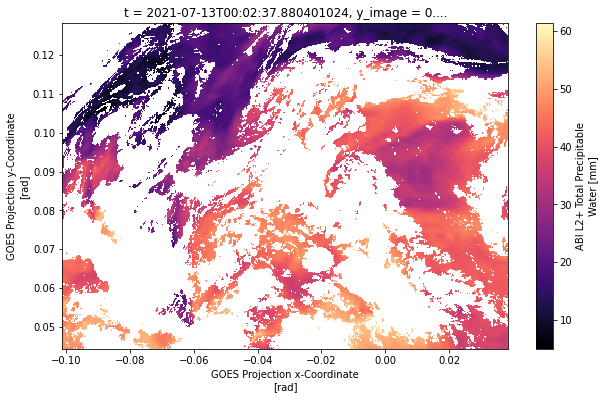

In [30]:
data = xr.load_dataset(dat_url)

fig = plt.figure(figsize=(10, 6))
data.TPW.plot(cmap="magma")

From this map it is difficult to determine intuitively where we are looking. We also see that the coordinate axis that is being used automatically is also not super helpful. 

So here is the solution.
### Mapping GOES data with Basemap

In [32]:
data = xr.load_dataset(dat_url)

# Start of geometric transformation 
proj_info = data.variables['goes_imager_projection']
lon_origin = proj_info.attrs["longitude_of_projection_origin"]
H = proj_info.attrs["perspective_point_height"] + proj_info.attrs["semi_major_axis"]
r_eq = proj_info.attrs["semi_major_axis"]
r_pol = proj_info.attrs["semi_minor_axis"]

lat_rad_1d = data.variables['x'][:]
lon_rad_1d = data.variables['y'][:]

lat_rad, lon_rad = np.meshgrid(lat_rad_1d, lon_rad_1d)

lambda_0 = (lon_origin * np.pi) / 180.0

a_var = np.power(np.sin(lat_rad), 2.0) + (np.power(np.cos(lat_rad), 2.0) * (
    np.power(np.cos(lon_rad), 2.0) + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(lon_rad), 2.0))))
b_var = -2.0 * H * np.cos(lat_rad) * np.cos(lon_rad)
c_var = (H ** 2.0) - (r_eq ** 2.0)

r_s = (-1.0 * b_var - np.sqrt((b_var ** 2) - (4.0 * a_var * c_var))) / (2.0 * a_var)

s_x = r_s * np.cos(lat_rad) * np.cos(lon_rad)
s_y = - r_s * np.sin(lat_rad)
s_z = r_s * np.cos(lat_rad) * np.sin(lon_rad)

lat = (180.0 / np.pi) * (
np.arctan(((r_eq * r_eq) / (r_pol * r_pol)) * (s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y)))))
lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)\
# End of geometric transformation

goes_data = data.variables['TPW']


C:\Users\spenc\AppData\Local\Temp\ipykernel_23448\1200513068.py:22: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0 * b_var - np.sqrt((b_var ** 2) - (4.0 * a_var * c_var))) / (2.0 * a_var)


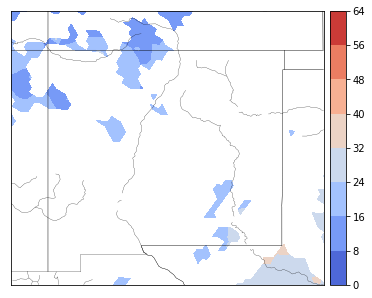

In [33]:
bbox = [-110, 31, -102, 38]

fig = plt.figure(figsize=(6, 6))

n_add = 0
m = Basemap(llcrnrlon=bbox[0] - n_add,
            llcrnrlat=bbox[1] - n_add,
            urcrnrlon=bbox[2] + n_add,
            urcrnrlat=bbox[3] + n_add,
            resolution='i',
            projection='cyl')

m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.25)
m.drawstates(linewidth=0.25)
m.drawrivers(linewidth=0.25)

m.contourf(lon, lat, goes_data, cmap="coolwarm", latlon=True)
m.colorbar()

plt.show()